##### Project - Gesture Recognition

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Gesture	Corresponding Action

Thumbs Up	Increase the volume.

Thumbs Down	Decrease the volume.

Left Swipe	'Jump' backwards 10 seconds.

Right Swipe	'Jump' forward 10 seconds.

Stop	Pause the movie.

Objectives:

Generator: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
## Checking the GPU configuration

!nvidia-smi

Tue Aug  1 10:00:51 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.25                 Driver Version: 536.25       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0              25W /  95W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import secrets

In [3]:
# Importing the necessary libraries

import imageio
import numpy as np
import os
# from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [4]:
import numpy as np
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
# tf.set_random_seed(30)
#tf.random.set_seed

In [5]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [6]:
from keras.models import Sequential, Model
from keras.layers import Conv2D
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [7]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [8]:
project_folder="../data"

In [9]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

#### Generator

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [10]:
from skimage.transform import resize

class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

#### Model

Here we make the model using different functionalities that Keras provides. We need to remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. We would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters with optimized memory utilitzation.

#### Sample Model

In [11]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 30, 160, 160, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 80, 80, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4

#### Sample Cropping

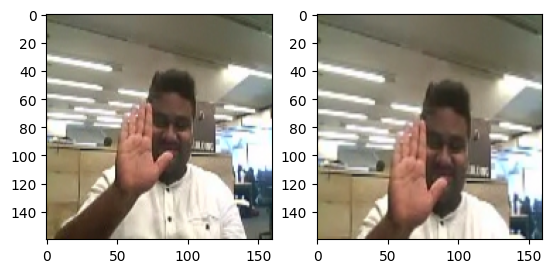

In [13]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])  

#### Experimenting with Image resolution, number of frames to use and batch_size

In [15]:
conv_3d1.train_model(conv_3d1_model)

39/67 [================>.............] - ETA: 2:58 - loss: 1.5926 - categorical_accuracy: 0.4205

In [ ]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109538912773 Gigs


#### Making a trade off between frames and batch_size 

Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [ ]:
# conv_3d1=ModelConv3D1()
# conv_3d1.initialize_path(project_folder)
# conv_3d1.initialize_image_properties(image_height=100,image_width=100)
# conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=30,num_epochs=2)
# conv_3d1_model=conv_3d1.define_model()
# print("Total Params:", conv_3d1_model.count_params())
# conv_3d1.train_model(conv_3d1_model)

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
34/34 [==============================] - ETA: 0s - loss: 1.5087 - categorical_accuracy: 0.4268
Epoch 1: val_loss improved from inf to 1.85382, saving model to model_init_2023-07-3110_17_05.596642\model-00001-1.50870-0.42685-1.85382-0.19000.h5
34/34 [==============================] - 188s 5s/step - loss: 1.5087 - categorical_accuracy: 0.4268 - val_loss: 1.8538 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 1.0646 - categorical_accuracy: 0.5882
Epoch 2: val_loss did not improve from 1.85382
34/34 [==============================] - 184s 5s/step - loss: 1.0646 - categorical_accuracy: 0.5882 - val_loss: 2.1324 - val_categorical_accuracy: 0.1700 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.3910 - categorical_accuracy: 0.4917
Epoch 1: val_loss improved from inf to 7.49518, saving model to model_init_2023-07-3110_23_25.805884\model-00001-1.39105-0.49170-7.49518-0.20000.h5
45/45 [==============================] - 451s 10s/step - loss: 1.3910 - categorical_accuracy: 0.4917 - val_loss: 7.4952 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.7536 - categorical_accuracy: 0.7179
Epoch 2: val_loss did not improve from 7.49518
45/45 [==============================] - 454s 10s/step - loss: 0.7536 - categorical_accuracy: 0.7179 - val_loss: 10.4255 - val_categorical_accuracy: 0.2500 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.6372 - categorical_accuracy: 0.4118 
Epoch 1: val_loss improved from inf to 2.55086, saving model to model_init_2023-07-3022_44_20.838859\model-00001-1.63716-0.41176-2.55086-0.21000.h5
23/23 [==============================] - 244s 11s/step - loss: 1.6372 - categorical_accuracy: 0.4118 - val_loss: 2.5509 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 0.9987 - categorical_accuracy: 0.6259 
Epoch 2: val_loss did not improve from 2.55086
23/23 [==============================] - 242s 11s/step - loss: 0.9987 - categorical_accuracy: 0.6259 - val_loss: 3.8670 - val_categorical_accuracy: 0.2000 - lr: 0.0010


:> As we see from the above experiments "image resolution" and number of frames in sequence have more impact on training time than batch_size

:> We can consider the Batch Size around 15-40

:> We will change the resolution 160160, 120120 according the model performance

#### Model 1

Base Model - Batch Size = 40 and No. of Epochs = 15

In [14]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation_12 (Activation)  (None, 20, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization_18 (Ba  (None, 20, 160, 160, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 10, 80, 80, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 80, 80, 32)   

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5552 - categorical_accuracy: 0.4299 
Epoch 1: val_loss improved from inf to 2.06547, saving model to model_init_2023-07-3108_24_44.541837\model-00001-1.55525-0.42986-2.06547-0.23000.h5
17/17 [==============================] - 403s 24s/step - loss: 1.5552 - categorical_accuracy: 0.4299 - val_loss: 2.0655 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.9713 - categorical_accuracy: 0.6350 
Epoch 2: val_loss improved from 2.06547 to 1.86059, saving model to model_init_2023-07-3108_24_44.541837\model-00002-0.97132-0.63499-1.86059-0.22000.h5
17/17 [==============================] - 382s 22s/step - loss: 0.9713 - categorical_accuracy: 0.6350 - val_loss: 1.8606 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.6940 - categorical_accuracy: 0.7436 
Epoch 3: val_loss did

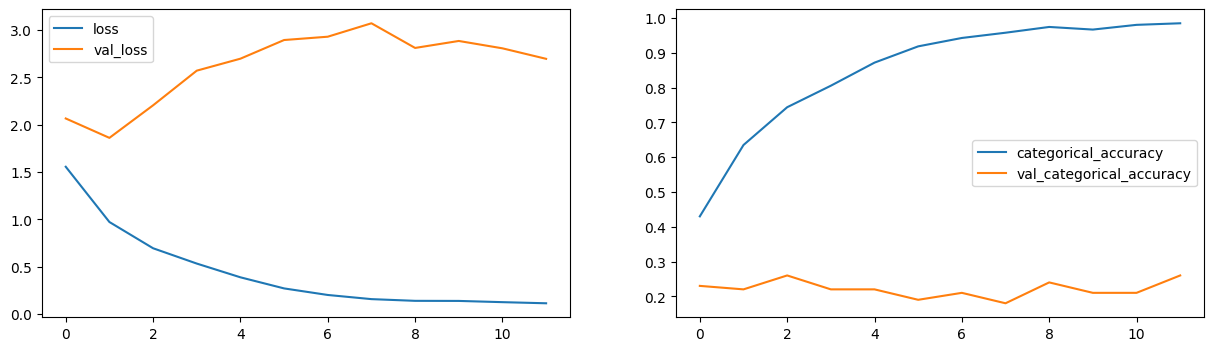

In [ ]:
plot(history_model1)

#### Model 2

Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [13]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 20, 160, 160, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 80, 80, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    1

In [14]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8746 - categorical_accuracy: 0.3967 
Epoch 1: val_loss improved from inf to 3.00485, saving model to model_init_2023-07-3112_21_56.484887\model-00001-1.87463-0.39668-3.00485-0.22000.h5
34/34 [==============================] - 718s 21s/step - loss: 1.8746 - categorical_accuracy: 0.3967 - val_loss: 3.0049 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5123 - categorical_accuracy: 0.4842 
Epoch 2: val_loss improved from 3.00485 to 2.33509, saving model to model_init_2023-07-3112_21_56.484887\model-00002-1.51228-0.48416-2.33509-0.34000.h5
34/34 [==============================] - 715s 21s/step - loss: 1.5123 - categorical_accuracy: 0.4842 - val_loss: 2.3351 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1681 - categorical_accuracy: 0.5958 
Epoch 3: val_loss did not improve from 2.33

: 

: 

In [13]:
plot(history_model2)

NameError: name 'history_model2' is not defined

#### We can see val_loss did not improve from 1.24219 so earlystopping stops the epoch automatically!!

Last Epoch stop on 15/25!! good job earlystopping ;)

Best weights save automatically. The validation accuracy of 52% and training accuracy of 65%. Next we will try to reduce the filter size and image resolution and see if get better results. 

Moreover since we see minor oscillations in loss, let's try lowering the learning rate to 0.0002

#### Model 3

Reduce filter size to (2,2,2) and image res to 120 x 120, - Batch Size = 30 and No. of Epochs = 25

In [13]:

class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=20)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16   400       
                             )                                   
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 16, 120, 120, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 8, 60, 60, 16)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     4

In [15]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613


Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.7540 - categorical_accuracy: 0.4449
Epoch 1: val_loss improved from inf to 2.30562, saving model to model_init_2023-07-3115_07_19.347745\model-00001-1.75404-0.44495-2.30562-0.16000.h5
23/23 [==============================] - 223s 10s/step - loss: 1.7540 - categorical_accuracy: 0.4449 - val_loss: 2.3056 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.0909 - categorical_accuracy: 0.6207
Epoch 2: val_loss did not improve from 2.30562
23/23 [==============================] - 221s 10s/step - loss: 1.0909 - categorical_accuracy: 0.6207 - val_loss: 4.1846 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.8857 - categorical_accuracy: 0.6750
Epoch 3: val_loss did not improve from 2.30562
23/23 [==============================] - 220s 10s/step - loss: 0.8857 - categorical_accuracy: 0.6750 - v

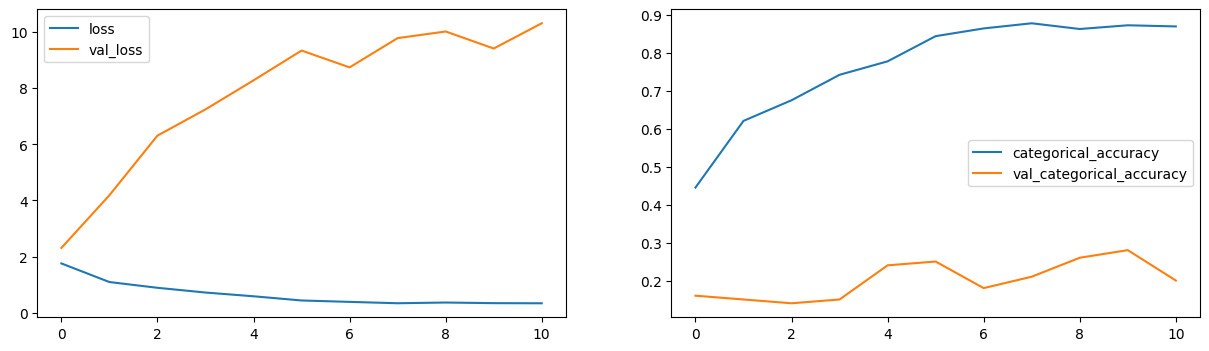

In [16]:
plot(history_model3)

Model has a best validation accuracy of 72% and training accuracy of 76% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

#### Model 4 -

Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [17]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [18]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_6 (Bat  (None, 16, 120, 120, 16   64        
 chNormalization)            )                                   
                                                                 
 conv3d_5 (Conv3D)           (None, 16, 120, 120, 16   6928      
                             )                                   
                                                                 
 activation_5 (Activation)   (None, 16, 120, 120, 16  

In [19]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.0444 - categorical_accuracy: 0.3537 
Epoch 1: val_loss improved from inf to 1.66801, saving model to model_init_2023-07-3115_55_59.703069\model-00001-2.04440-0.35370-1.66801-0.25000.h5
34/34 [==============================] - 860s 25s/step - loss: 2.0444 - categorical_accuracy: 0.3537 - val_loss: 1.6680 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5186 - categorical_accuracy: 0.4834 
Epoch 2: val_loss did not improve from 1.66801
34/34 [==============================] - 885s 26s/step - loss: 1.5186 - categorical_accuracy: 0.4834 - val_loss: 2.8900 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3438 - categorical_accuracy: 0.5264 
Epoch 3: val_loss did not improve from 1.66801
34/34 [==============================] - 897s 26s/step - loss: 1.3438 - categorical_accuracy: 0.5264 

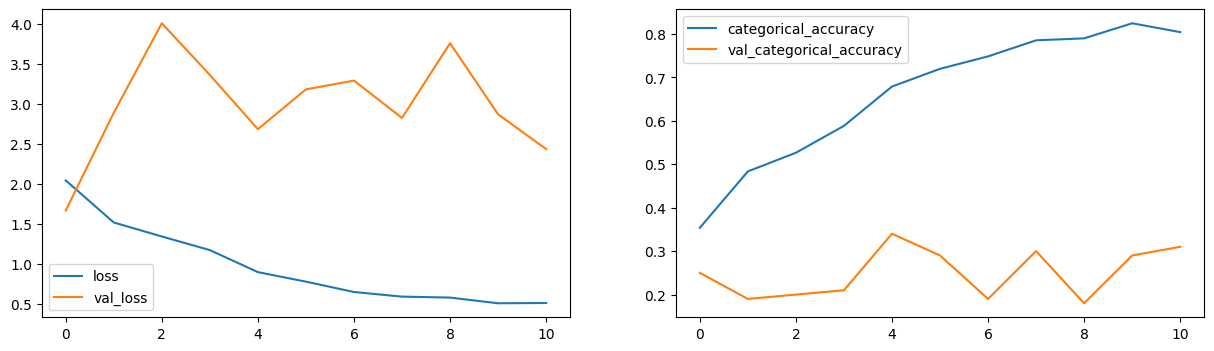

In [20]:
plot(history_model4)

With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

#### Model 5

Adding dropout at convolution layers

In [15]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_6 (Bat  (None, 16, 120, 120, 16   64        
 chNormalization)            )                                   
                                                                 
 conv3d_5 (Conv3D)           (None, 16, 120, 120, 16   6928      
                             )                                   
                                                                 
 activation_5 (Activation)   (None, 16, 120, 120, 16  

In [17]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.6774 - categorical_accuracy: 0.3929 
Epoch 1: val_loss improved from inf to 1.98790, saving model to model_init_2023-07-3122_03_36.913394\model-00001-1.67738-0.39291-1.98790-0.21000.h5
34/34 [==============================] - 912s 27s/step - loss: 1.6774 - categorical_accuracy: 0.3929 - val_loss: 1.9879 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.2511 - categorical_accuracy: 0.5603 
Epoch 2: val_loss did not improve from 1.98790
34/34 [==============================] - 899s 26s/step - loss: 1.2511 - categorical_accuracy: 0.5603 - val_loss: 2.7923 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.8957 - categorical_accuracy: 0.6765 
Epoch 3: val_loss did not improve from 1.98790
34/34 [==============================] - 860s 25s/step - loss: 0.8957 - categor

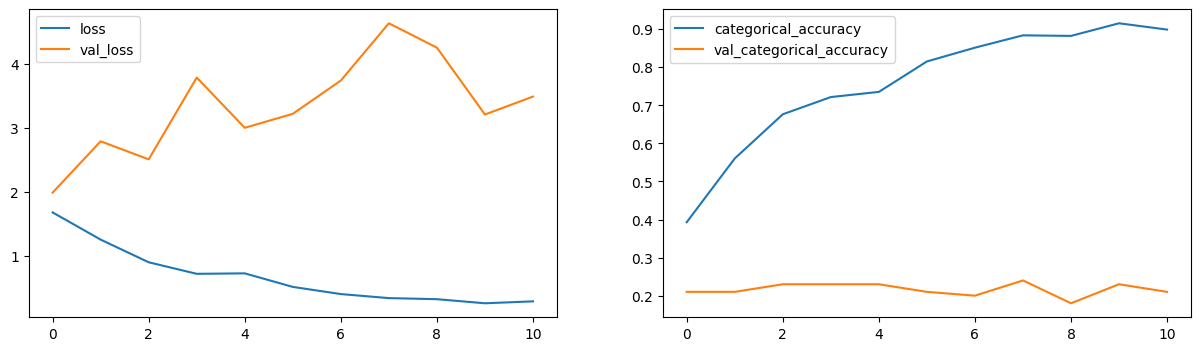

In [18]:
plot(history_model5)

Ohh! Overfitting again!! Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.

All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

#### Model 6

Reducing the number of parameters

In [19]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [20]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 100, 100, 16   1312      
                             )                                   
                                                                 
 activation_12 (Activation)  (None, 16, 100, 100, 16   0         
                             )                                   
                                                                 
 batch_normalization_16 (Ba  (None, 16, 100, 100, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_8 (MaxPoolin  (None, 8, 50, 50, 16)     0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 50, 50, 32)    

In [21]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4122 - categorical_accuracy: 0.4834
Epoch 1: val_loss improved from inf to 3.10613, saving model to model_init_2023-08-0107_04_43.537622\model-00001-1.41220-0.48341-3.10613-0.21000.h5
34/34 [==============================] - 191s 6s/step - loss: 1.4122 - categorical_accuracy: 0.4834 - val_loss: 3.1061 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9127 - categorical_accuracy: 0.6433
Epoch 2: val_loss did not improve from 3.10613
34/34 [==============================] - 194s 6s/step - loss: 0.9127 - categorical_accuracy: 0.6433 - val_loss: 5.5133 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.6947 - categorical_accuracy: 0.7293
Epoch 3: val_loss did not improve from 3.10613
34/34 [==============================] - 193s 6s/step - loss: 0.6947 - categorical_accuracy: 0.7293 - val_

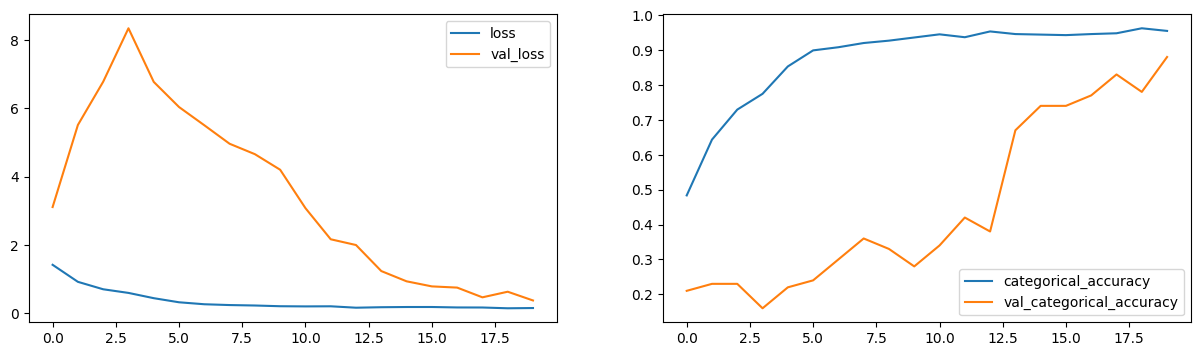

In [22]:
plot(history_model6)

Model 7 - Reducing the number of parameters again

In [23]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_16 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_22 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 8, 60, 60, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 60, 60, 32)    

In [25]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4452 - categorical_accuracy: 0.4449
Epoch 1: val_loss improved from inf to 2.17546, saving model to model_init_2023-08-0108_11_03.020161\model-00001-1.44515-0.44495-2.17546-0.22000.h5
34/34 [==============================] - 334s 10s/step - loss: 1.4452 - categorical_accuracy: 0.4449 - val_loss: 2.1755 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0377 - categorical_accuracy: 0.5958
Epoch 2: val_loss did not improve from 2.17546
34/34 [==============================] - 308s 9s/step - loss: 1.0377 - categorical_accuracy: 0.5958 - val_loss: 2.8398 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8240 - categorical_accuracy: 0.6727
Epoch 3: val_loss did not improve from 2.17546
34/34 [==============================] - 300s 9s/step - loss: 0.8240 - categorical_accuracy: 0.6727 - val

: 

: 

In [ ]:
plot(history_model7)

For the above low memory foot print model the best validation accuracy of 73%

Model 8 - CNN- LSTM Model

In [15]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [16]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 18, 120, 120, 16   448       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 18, 120, 120, 16   64        
 stributed)                  )                                   
                                                                 
 time_distributed_2 (TimeDi  (None, 18, 60, 60, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 18, 60, 60, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 18, 60, 60, 32)   

In [17]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3352 - categorical_accuracy: 0.4284
Epoch 1: val_loss improved from inf to 1.87862, saving model to model_init_2023-08-0108_48_42.694574\model-00001-1.33520-0.42836-1.87862-0.22000.h5
34/34 [==============================] - 222s 7s/step - loss: 1.3352 - categorical_accuracy: 0.4284 - val_loss: 1.8786 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0383 - categorical_accuracy: 0.5905
Epoch 2: val_loss improved from 1.87862 to 1.83809, saving model to model_init_2023-08-0108_48_42.694574\model-00002-1.03826-0.59050-1.83809-0.27000.h5
34/34 [==============================] - 207s 6s/step - loss: 1.0383 - categorical_accuracy: 0.5905 - val_loss: 1.8381 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8354 - categorical_accuracy: 0.6757
Epoch 3: val_loss did not 

: 

: 

In [ ]:
plot(history_model8)

For CNN - LSTM model we get a best validation accuracy of 85%
As we see more cases of overfitting, lets augment the data with *slight rotation* as well and run the same set of models again

Let's apply some data augmentation & check the model performance.

In [14]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

In [16]:
from matplotlib.image import imread

class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

NameError: name 'imresize' is not defined

#### Model 9 with Augmentation

(3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [17]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [18]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation_4 (Activation)   (None, 20, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization_6 (Bat  (None, 20, 160, 160, 16   64        
 chNormalization)            )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 10, 80, 80, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 80, 80, 32)   

In [19]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981


NameError: name 'imresize' is not defined

In [20]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [ ]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

In [ ]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)plot(history_model10)

In [ ]:
plot(history_model10)

#### Model 11 with Augmentation

Adding more layers - Similar to model 4

In [ ]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

In [ ]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

In [ ]:
plot(history_model11)

#### Model 12 with Augmentation

Adding dropouts - Similar to Model 5

In [ ]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

In [ ]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

In [ ]:
plot(history_model12)

NameError: name 'plot' is not defined

Model is overfitting badly !!

#### Model 13 with Augmentation

Reducing network parameters - Similar to Model 6

In [ ]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

In [ ]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

In [ ]:
plot(history_model13)

##### Model 14 with Augmentation

Reducing network parameters again - Similar to model 7

In [ ]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

In [ ]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

In [ ]:
plot(history_model14)

#### Model 15 with Augmentation

CNN LSTM with GRU - Similar to Model 8

In [ ]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

In [ ]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

In [ ]:
plot(history_model15)

We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy


#### Model 16 - Let us bring in Transfer Learning !! :)

In [ ]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
# in the nimblebox.ai platform. 

from keras.applications import mobilenet

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

In [ ]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

In [ ]:
plot(history_model16)

We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

Model 17 - Transfer Learning with GRU and training all weights

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

In [ ]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

In [ ]:
plot(history_model17)

Awesome results! 98% Training accuracy and 93% validation accuracy :)

Consolidated Final Models

After doing all the experiments, we finalized Model 8 - CNN+LSTM, which performed well.
Reason:

- (Training Accuracy : 93%, Validation Accuracy : 85%)

- Number of Parameters(1,657,445)less according to other models performance

- Learning rate gradually decreacing after 16 Epoch

The best weights of CNN-LSTM: model-00020-0.19649-0.93514-0.45695-0.85000.h5 (19 MB). we considered this weight for model testing, Let's have look at the performance below

Loading model and Testing

In [ ]:
# import time
# from keras.models import load_model
# model = load_model('model_init_2020-06-2522_00_52.036987/model-00020-0.19649-0.93514-0.45695-0.85000.h5')

In [ ]:
# test_generator=RNNCNN1()
# test_generator.initialize_path(project_folder)
# test_generator.initialize_image_properties(image_height=120,image_width=120)
# test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

# g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
# batch_data, batch_labels=next(g)

In [ ]:
# batch_labels

In [ ]:

# print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))